In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Dataset Introduction
This dataset contains two sets.

The first set is all goods, the second set contains goods and defective products.

You need to classify the products into defective ones or not, and calculate the accuracy.

The benchmark is accuracy.

In [2]:
import glob

DATASET = 'cable'

image_size = 256
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root_dir = root
        self.transform = transform
        self.image_paths = glob.glob(f"{root}/*.png")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = 0
        return img, label

train_dataset = CustomDataset(root=f'./data/train/{DATASET}', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=11)
val_dataset = CustomDataset(root=f'./data/val/{DATASET}', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=11)


print("train: ", len(train_dataset))
print("val: ", len(val_dataset))

train:  179
val:  45


In [3]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 4090 , device num:0


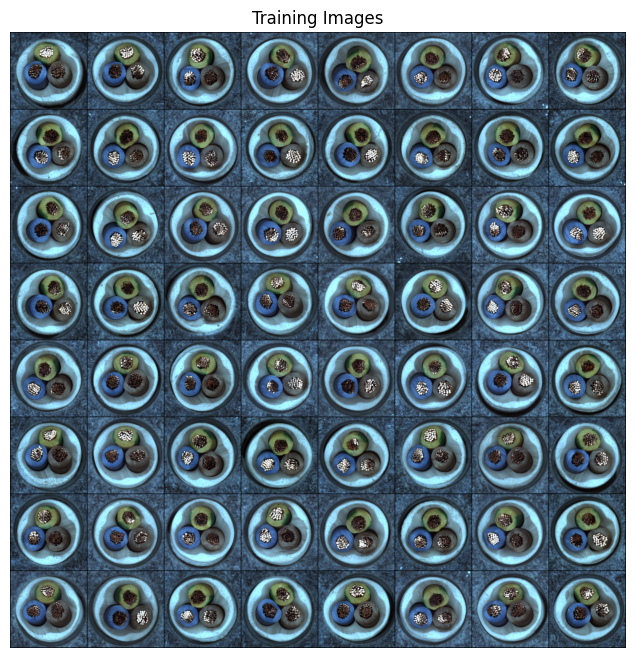

In [4]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray')

In [5]:
import torch
import torch.nn as nn
from torchvision import models

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # (C, H, W) -> (32, H/2, W/2)
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # (64, H/4, W/4)
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),# (128, H/8, W/8)
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128 * (image_size // 8) * (image_size // 8), 512),
            nn.LeakyReLU(),
            nn.Linear(512, latent_dim * 2)  # mu and logvar
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 128 * (image_size // 8) * (image_size // 8)),
            nn.LeakyReLU(),
            nn.Unflatten(1, (128, image_size // 8, image_size // 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output range [-1, 1]
        )

        self.apply(self.initialize_weights_kaiming)
    
    def initialize_weights_kaiming(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def initialize_weights_xavier(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('leaky_relu'))
            if m.bias is not None:
                nn.init.zeros_(m.bias)


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=-1)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [6]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

In [7]:
train_losses = []
val_losses = []

def train_vae(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    global train_losses, val_losses
    train_losses.clear()
    val_losses.clear()
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(data)
            loss = loss_function(recon_x, data, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        scheduler.step()

        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                recon_x, mu, logvar = model(data)
                val_loss += loss_function(recon_x, data, mu, logvar).item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}.. Train Loss: {train_loss:.4f}.. Val Loss: {val_loss:.4f}")

In [8]:
latent_dim = 128
model = VAE(latent_dim).to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

train_vae(model, train_loader, val_loader, optimizer, scheduler=scheduler, epochs=500)

Epoch 1/500.. Train Loss: 151007.2402.. Val Loss: 710703331.5556
Epoch 2/500.. Train Loss: 778229290.9050.. Val Loss: 4596311.4667
Epoch 3/500.. Train Loss: 4979268.2905.. Val Loss: 70707052.0889
Epoch 4/500.. Train Loss: 74252900.1117.. Val Loss: 5007052.4444
Epoch 5/500.. Train Loss: 5324021.9888.. Val Loss: 1130774.6667
Epoch 6/500.. Train Loss: 1183424.5363.. Val Loss: 371578.6889
Epoch 7/500.. Train Loss: 380247.4190.. Val Loss: 231342.9333
Epoch 8/500.. Train Loss: 234148.2011.. Val Loss: 194910.6667
Epoch 9/500.. Train Loss: 197273.1844.. Val Loss: 178963.1111
Epoch 10/500.. Train Loss: 180632.4022.. Val Loss: 168771.0778
Epoch 11/500.. Train Loss: 170158.4804.. Val Loss: 160363.5778
Epoch 12/500.. Train Loss: 161113.6089.. Val Loss: 150876.0444
Epoch 13/500.. Train Loss: 151924.7709.. Val Loss: 140259.6889
Epoch 14/500.. Train Loss: 141755.2402.. Val Loss: 129747.2556
Epoch 15/500.. Train Loss: 131007.5196.. Val Loss: 117974.9556
Epoch 16/500.. Train Loss: 119709.3743.. Val Los

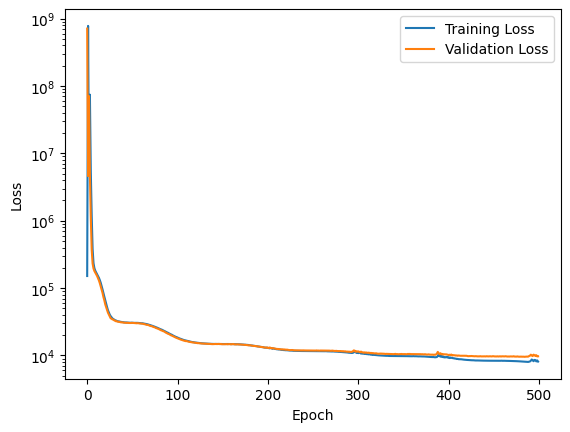

In [9]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

## Calculate the reconstruction loss
The reconstruction loss between good products and defective products should have difference.

You can use the following codes to evaluate the reconstruction loss, and find something useful information.

good avg:  9640.022696659482
defective avg:  11806.03348441746


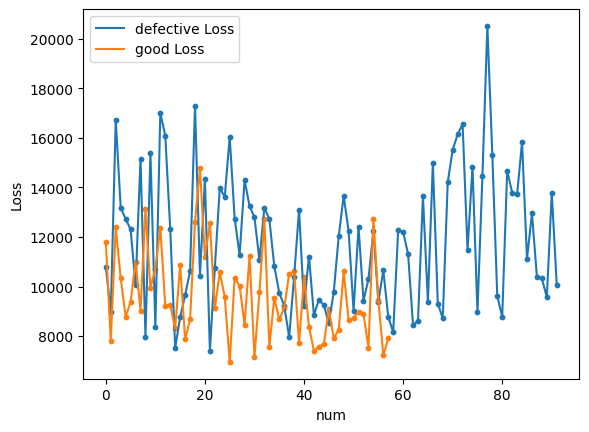

In [10]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt

def test(image_path, vae, device):
    img = Image.open(image_path)
    img = transform(img).to(device)
    img = img.unsqueeze(0)

    vae.eval()
    with torch.no_grad():
        recon, mu, log_var = vae(img)
        test_loss = loss_function(recon, img, mu, log_var)
        return test_loss.item()

testimg_dir = f'./data/test/{DATASET}/good'
testimg_dir2 = f'./data/test/{DATASET}/error'

good = []
error = []
for img_file in os.listdir(testimg_dir):
    img_path = os.path.join(testimg_dir, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        good.append(test(img_path, model, device))

for img_file in os.listdir(testimg_dir2):
    img_path = os.path.join(testimg_dir2, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        error.append(test(img_path, model, device))

plt.plot(error, label='defective Loss')
plt.scatter(range(len(error)), error, s=10)
plt.plot(good, label='good Loss')
plt.scatter(range(len(good)), good, s=10)
plt.xlabel('num')
plt.ylabel('Loss')
plt.legend()

print("good avg: ", sum(good)/len(good))    
print("defective avg: ", sum(error)/len(error))

## Calculate Accuracy
You need to calculate the accuracy of products' predictions. 

A easy way is to use the reconstruction loss to distinguish between goods and defective ones.

It is not restricted to use this way, you also can use another methods and write they into report.

In [11]:
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % (2**32 - 1)
    np.random.seed(worker_seed)

set_seed(42)

In [12]:
from sklearn.metrics import f1_score

def calculate_accuracy_and_f1(threshold=100.0):
    set_seed(42)
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    # Good products (正類)
    for img_file in os.listdir(testimg_dir):
        img_path = os.path.join(testimg_dir, img_file)
        if os.path.isfile(img_path):
            loss = test(img_path, model, device)
            true_labels.append(1)  # 正類標籤
            if loss < threshold:
                predicted_labels.append(1)  # 預測正類
                correct += 1
            else:
                predicted_labels.append(0)  # 預測負類
            total += 1

    # Defective products (負類)
    for img_file in os.listdir(testimg_dir2):
        img_path = os.path.join(testimg_dir2, img_file)
        if os.path.isfile(img_path):
            loss = test(img_path, model, device)
            true_labels.append(0)  # 負類標籤
            if loss >= threshold:
                predicted_labels.append(0)  # 預測負類
                correct += 1
            else:
                predicted_labels.append(1)  # 預測正類
            total += 1

    accuracy = correct / total * 100

    # 計算 F1-score
    f1 = f1_score(true_labels, predicted_labels)

    return accuracy, f1


def find_best_threshold(low=0, high=2000, tolerance=1):
    """
    使用三分搜尋找到最佳的 threshold。
    """
    set_seed(42)
    best_threshold = 0
    best_accuracy = 0

    while high - low > tolerance:
        # 計算兩個中點
        mid1 = low + (high - low) // 3
        mid2 = high - (high - low) // 3

        # 計算兩個中點的準確率
        accuracy1, f11 = calculate_accuracy_and_f1(mid1)
        accuracy2, f12 = calculate_accuracy_and_f1(mid2)

        print(accuracy1, f11, mid1, accuracy2, f12, mid2)

        # 比較兩個中點的準確率
        if accuracy1 > accuracy2:
            if accuracy1 > best_accuracy:
                best_accuracy = accuracy1
                best_threshold = mid1
            high = mid2 - 1
        else:
            if accuracy2 > best_accuracy:
                best_accuracy = accuracy2
                best_threshold = mid2
            low = mid1 + 1

    return best_threshold, best_accuracy

In [13]:
find_best_threshold(0, 20000)

61.33333333333333 0.0 6666 57.99999999999999 0.6440677966101694 13334
61.33333333333333 0.0 4444 66.66666666666666 0.5 8889
64.66666666666666 0.15873015873015872 7407 63.33333333333333 0.5864661654135338 10371
61.33333333333333 0.0 6420 68.0 0.4 8395
65.33333333333333 0.2571428571428571 7737 67.33333333333333 0.5148514851485149 9054
68.0 0.4418604651162791 8615 67.33333333333333 0.5663716814159292 9493
68.0 0.4 8322 67.33333333333333 0.5148514851485149 8908
68.0 0.38461538461538464 8127 66.66666666666666 0.3902439024390244 8518
66.66666666666666 0.32432432432432434 7997 67.33333333333333 0.379746835443038 8258
68.0 0.38461538461538464 8171 68.0 0.4 8344
68.0 0.4 8287 68.0 0.4 8402
68.0 0.4 8364 67.33333333333333 0.3950617283950617 8441
68.0 0.4 8338 68.0 0.4 8390
68.0 0.4 8372 67.33333333333333 0.3950617283950617 8407
68.0 0.4 8361 68.0 0.4 8384
68.0 0.4 8376 68.0 0.4 8392
68.0 0.4 8386 68.0 0.4 8397
68.0 0.4 8393 68.0 0.4 8400
68.0 0.4 8398 68.0 0.4 8402
68.0 0.4 8401 68.0 0.4 8404
68

(8395, 68.0)

In [ ]:
calculate_accuracy_and_f1(234)

(61.33333333333333, np.float64(0.0))

: 